In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
  
from sklearn.metrics import classification_report, confusion_matrix
  
# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
  
import cv2
  
import warnings
warnings.filterwarnings('ignore')

In [28]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# datasets
labels = pd.read_csv("/content/drive/My Drive/Images/train_labels.csv", delimiter=';')
sample = pd.read_csv('/content/drive/My Drive/Images/test_labels.csv', delimiter=';')
  
# folders paths
train_path = "/content/drive/MyDrive/Images/train"
test_path = "/content/drive/MyDrive/Images/test"

In [54]:
sample.head()

,id,bottle
0,aug_0_7418,Balans
1,aug_0_7419,Balans
2,aug_0_7525,Balans
3,aug_0_7529,Balans
4,aug_0_7574,Balans


In [55]:
labels.head()

,id,bottle
0,aug_0_8243,Balans
1,aug_0_8289,Balans
2,aug_0_8341,Balans
3,aug_0_8475,Balans
4,aug_0_8484,Balans


In [56]:
def to_jpg(id):
    return id+".jpg"

labels['id'] = labels['id'].apply(to_jpg)
sample['id'] = sample['id'].apply(to_jpg)

In [57]:
gen = ImageDataGenerator(
                  rescale=1./255.,
                  horizontal_flip = True,
                  validation_split=0.2 # training: 80% data, validation: 20% data
                 )
  
train_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'bottle',
    subset="training",
    color_mode="rgb",
    target_size = (150,150), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)
  
  
validation_generator = gen.flow_from_dataframe(
    labels, # dataframe
    directory = train_path, # images data path / folder in which images are there
    x_col = 'id',
    y_col = 'bottle',
    subset="validation",
    color_mode="rgb",
    target_size = (150,150), # image height , image width
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 452 validated image filenames belonging to 14 classes.
Found 113 validated image filenames belonging to 14 classes.


In [58]:
x,y = next(train_generator)
x.shape

(32, 150, 150, 3)

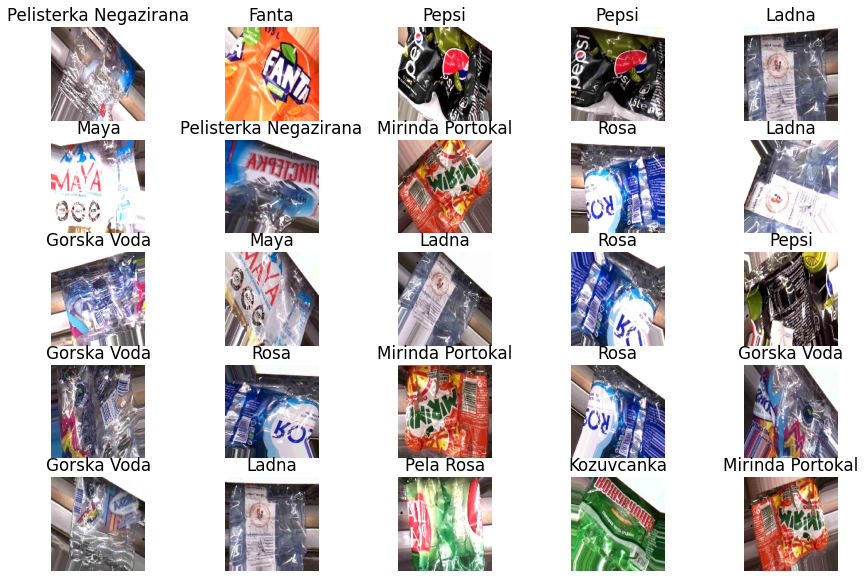

In [59]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list
  
def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
          
plot_images(x,y)

In [60]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3)
                     )
  
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
  
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(14, activation='softmax')
    ])

In [61]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_611 (Ba  (None, 3, 3, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 512)               786944    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                      

In [63]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

Trenirano prvo so 5 pa so 2 epohi

In [64]:
batch_size=32
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
					steps_per_epoch=STEP_SIZE_TRAIN,
					validation_data=validation_generator,
					validation_steps=STEP_SIZE_VALID,
					epochs=7,
					callbacks=[early])

Epoch 1/7
14/14 [==============================] - 64s 3s/step - loss: 2.3819 - accuracy: 0.2643 - val_loss: 5.3391 - val_accuracy: 0.0625
Epoch 2/7
14/14 [==============================] - 45s 3s/step - loss: 1.1153 - accuracy: 0.6143 - val_loss: 6.5774 - val_accuracy: 0.0833
Epoch 3/7
14/14 [==============================] - 43s 3s/step - loss: 0.6478 - accuracy: 0.8095 - val_loss: 8.8048 - val_accuracy: 0.0938
Epoch 4/7
14/14 [==============================] - 44s 3s/step - loss: 0.3198 - accuracy: 0.9190 - val_loss: 9.6129 - val_accuracy: 0.0625
Epoch 5/7
14/14 [==============================] - 44s 3s/step - loss: 0.1746 - accuracy: 0.9548 - val_loss: 9.5247 - val_accuracy: 0.0729
Epoch 6/7
14/14 [==============================] - 43s 3s/step - loss: 0.1594 - accuracy: 0.9500 - val_loss: 9.9431 - val_accuracy: 0.0938
Epoch 7/7
14/14 [==============================] - 44s 3s/step - loss: 0.1094 - accuracy: 0.9738 - val_loss: 9.5807 - val_accuracy: 0.0625


In [65]:
model.save("Model150.h5")

Text(0.5, 1.0, 'Grafik')

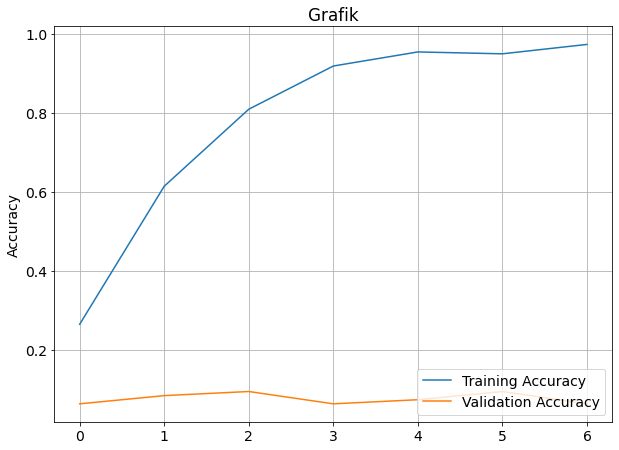

In [66]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Grafik')

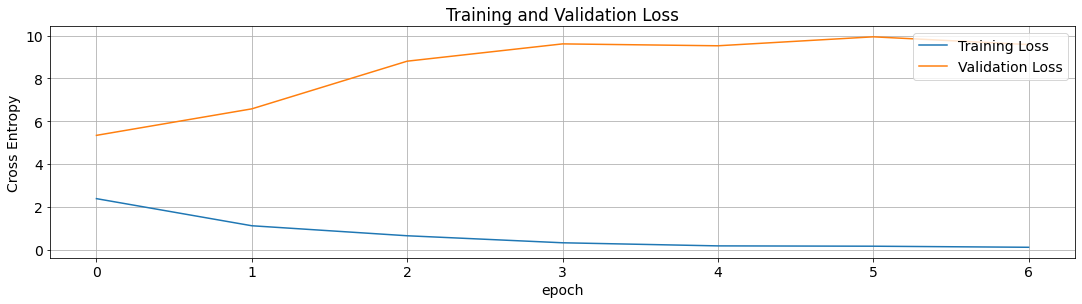

In [67]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [68]:

accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

4/4 [==============================] - 10s 2s/step - loss: 9.6558 - accuracy: 0.0796
[9.655826568603516, 0.0796460211277008]
Accuracy: 7.9646%
Loss:  9.655826568603516


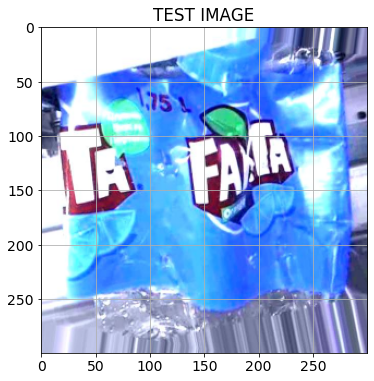

In [69]:
test_img_path = test_path+"/aug_0_1300.jpg"
  
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (300, 300)).reshape(-1, 300, 300, 3)/255
  
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [73]:
predictions = []
  
for image in sample.id:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (150, 150))
    img = tf.reshape(img, (-1, 150, 150, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))
  
my_submission = pd.DataFrame({'image_id': sample.id, 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)
  
# Submission file ouput
print("Submission File: \n---------------\n")
print(my_submission) # Displaying first five predicted output

Submission File: 
---------------

           image_id  label
0    aug_0_7418.jpg      4
1    aug_0_7419.jpg     11
2    aug_0_7525.jpg     11
3    aug_0_7529.jpg     11
4    aug_0_7574.jpg     11
..              ...    ...
233  aug_0_8720.jpg     13
234  aug_0_8728.jpg     13
235  aug_0_8734.jpg     13
236  aug_0_8799.jpg     13
237  aug_0_8853.jpg     13

[238 rows x 2 columns]
